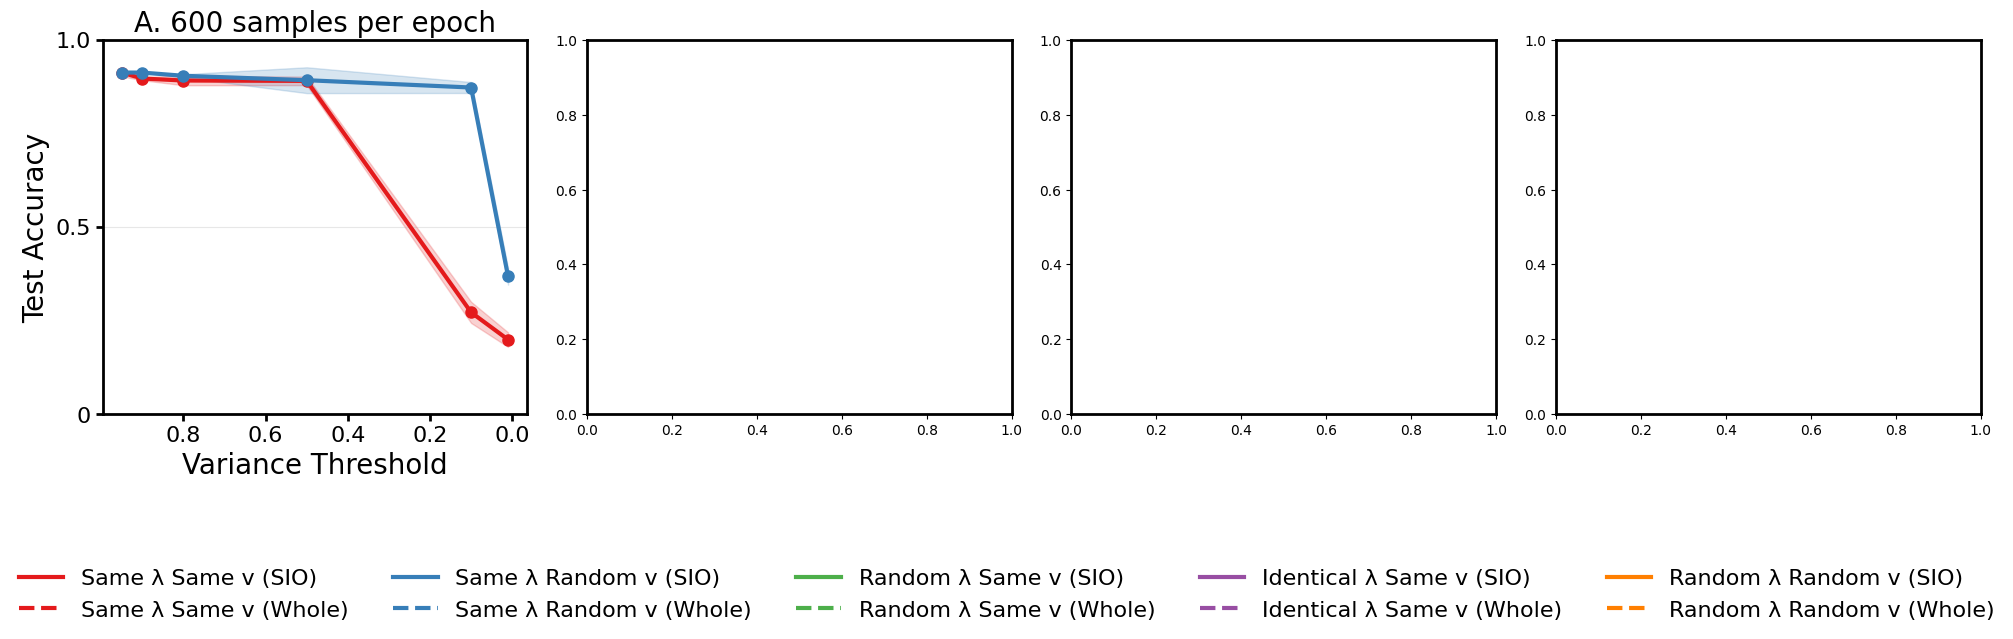

In [68]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

if '__file__' in globals():
    PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
else:
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
SELECTED_SAMPLES = ["1%", "2%", "5%", "10%"]

COLOR_MAP = {
    "Unlearnable_RNN_Low_Rank": "#E41A1C",
    "Unlearnable_RNN_Random_Structure_Same_Spectrum": "#377EB8",
    "Unlearnable_RNN_Random_Singular_Values": "#4DAF4A",
    "Unlearnable_RNN_Identical_Singular_Values": "#984EA3",
    "Unlearnable_RNN_Random_Singular_Values_Random_Spectrum": "#FF7F00"
}

EXP_DISPLAY_NAMES = {
    "Unlearnable_RNN_Low_Rank": "Same λ Same v",
    "Unlearnable_RNN_Random_Structure_Same_Spectrum": "Same λ Random v",
    "Unlearnable_RNN_Random_Singular_Values": "Random λ Same v",
    "Unlearnable_RNN_Identical_Singular_Values": "Identical λ Same v",
    "Unlearnable_RNN_Random_Singular_Values_Random_Spectrum": "Random λ Random v"
}

def load_results(selected_sample):
    target_samples = {"1%": 60, "2%": 120, "5%": 300, "10%": 600}[selected_sample]
    data = {}
    pattern = re.compile(
        r"^(?P<exp>\w+?)(_fewshot_\d+)?(_trial(?P<trial>\d+))?(\.whole)?(\.signed)?\.pkl$"
    )
  
    for fname in os.listdir(RESULTS_DIR):
        match = pattern.match(fname)
        if not match:
            continue
      
        exp_name = match.group("exp")
        if exp_name not in COLOR_MAP:
            continue
            
        is_whole = ".whole" in fname
        
        if "_fewshot" in fname:
            try:
                samples = int(fname.split("_fewshot_")[1].split("_")[0])
            except:
                continue
            if samples != target_samples:
                continue
      
        try:
            with open(os.path.join(RESULTS_DIR, fname), "rb") as f:
                results = pickle.load(f)
                if isinstance(results, dict):
                    exp_key = f"{exp_name}_whole" if is_whole else exp_name
                    if exp_key not in data:
                        data[exp_key] = {
                            "acc_lists": {},
                            "is_whole": is_whole
                        }
                    
                    trial_num = int(match.group("trial")) if match.group("trial") else 1
                    
                    for variance, trial_results in results.items():
                        if variance not in data[exp_key]["acc_lists"]:
                            data[exp_key]["acc_lists"][variance] = []
                        final_acc = trial_results["epoch_test_acc"][-1]
                        data[exp_key]["acc_lists"][variance].append(final_acc)
        except Exception as e:
            print(f"Error loading {fname}: {e}")
            continue
    
    for exp_key in data:
        for variance in data[exp_key]["acc_lists"]:
            acc_lists = data[exp_key]["acc_lists"][variance]
            if len(acc_lists) > 0:
                data[exp_key]["acc_lists"][variance] = np.array(acc_lists)
            else:
                print(f"Warning: No trials found for experiment {exp_key} with variance {variance}")
    return data

def plot_results(data, ax, selected_sample, panel_position):
    # Safely get one experiment dict to extract variance keys
    if not data:
        return
    sample_exp_data = next(iter(data.values()), None)
    if sample_exp_data is None or "acc_lists" not in sample_exp_data:
        return
    
    # Sort variance keys in descending order (exclude variance=1.0)
    variance_keys = [
        v for v in sorted(sample_exp_data["acc_lists"].keys(), reverse=True)
        if v != 1.0
    ]
    
    max_acc = 0.0
    for exp_key, exp_data in data.items():
        exp_name = exp_key.replace("_whole", "")
        if exp_name not in COLOR_MAP:
            continue
        
        x_vals = []
        mean_vals = []
        std_vals = []
        
        for var_key in variance_keys:
            if var_key not in exp_data["acc_lists"]:
                continue
            acc_array = exp_data["acc_lists"][var_key]
            if acc_array.size == 0:
                continue
            x_vals.append(float(var_key))
            mean_acc = np.mean(acc_array)
            std_acc = np.std(acc_array, ddof=1)
            mean_vals.append(mean_acc)
            std_vals.append(std_acc)
            max_acc = max(max_acc, mean_acc)
        
        if not x_vals:
            continue
        
        # Sort them again in case any missing data
        order = np.argsort(x_vals)[::-1]
        x_vals = np.array(x_vals)[order]
        mean_vals = np.array(mean_vals)[order]
        std_vals = np.array(std_vals)[order]
        
        linestyle = "--" if exp_data["is_whole"] else "-"
        ax.plot(
            x_vals, mean_vals,
            color=COLOR_MAP[exp_name],
            linestyle=linestyle,
            linewidth=3.0,
            marker="o",
            markersize=8
        )
        # Fill between mean ± std
        ax.fill_between(
            x_vals, mean_vals - std_vals, mean_vals + std_vals,
            color=COLOR_MAP[exp_name], alpha=0.2
        )
    
    # Axis settings
    ax.set_ylim(0, 1.0)
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_yticklabels(["0", "0.5", "1.0"], fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.invert_xaxis()  # from 1.0 down to smaller values
    ax.set_xlabel("Variance Threshold", fontsize=20)
    if panel_position == "A":
        ax.set_ylabel("Test Accuracy", fontsize=20)
    else:
        ax.set_ylabel("")
    
    target_samples = {"1%": 60, "2%": 120, "5%": 300, "10%": 600}[selected_sample]
    ax.set_title(f"{panel_position}. {target_samples*10} samples per epoch", fontsize=20)
    ax.grid(True, axis="y", alpha=0.3)
    ax.tick_params(width=2, length=5)

def create_custom_legend():
    legend_elements = []
    for exp_name, color in COLOR_MAP.items():
        display_name = EXP_DISPLAY_NAMES.get(exp_name, exp_name)
        legend_elements.append(
            Line2D([0], [0], color=color, lw=3.0, linestyle="-",
                   label=f"{display_name} (SIO)")
        )
        legend_elements.append(
            Line2D([0], [0], color=color, lw=3.0, linestyle="--",
                   label=f"{display_name} (Whole)")
        )
    return legend_elements

if __name__ == "__main__":
    plt.rcParams["axes.linewidth"] = 2.0
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    all_data = {}
    panel_labels = ["A", "B", "C", "D"]
    for idx, sample in enumerate(SELECTED_SAMPLES):
        data_for_sample = load_results(sample)
        all_data[sample] = data_for_sample
    
    for idx, sample in enumerate(SELECTED_SAMPLES):
        ax = axes[idx]
        plot_results(all_data[sample], ax, sample, panel_labels[idx])
    
    plt.tight_layout()
    legend = fig.legend(
        handles=create_custom_legend(),
        loc="center",
        bbox_to_anchor=(0.5, -0.2),
        ncol=5,
        frameon=False,
        fontsize=16
    )
    
    plt.savefig("variance_rank_plot.png", bbox_inches="tight", dpi=300)
    plt.show()
